### ■ Vertex AI Gemini ProとLangChainで実現するMultimodal RAG

・こちらの記事の内容 を、google colobで作成しました。

・下記内容に従って、動作確認できます。

・ただし、フォルダ作成やPDFの準備は行う必要があります。

https://zenn.dev/harappa80/articles/multimodal_rag

### ライブラリ類のインストール

In [ ]:
!pip install google-cloud-aiplatform==1.38.1
!pip install langchain==0.0.351
!pip install matplotlib==3.8.2
!pip install chromadb==0.4.20
!pip install pytesseract

In [ ]:
!pip install unstructured[all-docs]
!pip install poetry==1.6.1
!pip install Pillow==10.0.1

In [ ]:
!apt-get install -y poppler-utils
!apt install -y libtesseract-dev libleptonica-dev liblept5
!apt install -y tesseract-ocr

### ◼︎ VertexAI / Gemini API の確認

In [ ]:
import os
import vertexai
import google.generativeai as genai

# 環境変数 GOOGLE_APPLICATION_CREDENTIALS を設定 / 認証キーjsonは読み込めるディレクトリに入れてください。下記参照：content以下
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "＊＊＊＊＊.json"
# プロジェクトIDを設定
vertexai.init(project='＊＊＊＊＊')
# APIキーの設定
api_key = "＊＊＊＊＊＊"
genai.configure(api_key=api_key)

for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

In [ ]:
gemini_pro = genai.GenerativeModel("gemini-pro")
prompt = "日本で、美味しい魚料理を教えてください?"
response = gemini_pro.generate_content(prompt)
print(response.text)

### ■ PDFの読み込み。
・content フォルダに "dataset_dir" を作成して、読み込み用のPDFを保存してください。

・また "dataset_dir" 以下に images フォルダ作成

・初期ディレクトリから階層上に "content" フォルダがあり

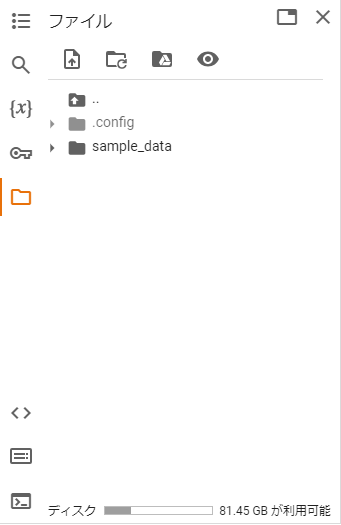

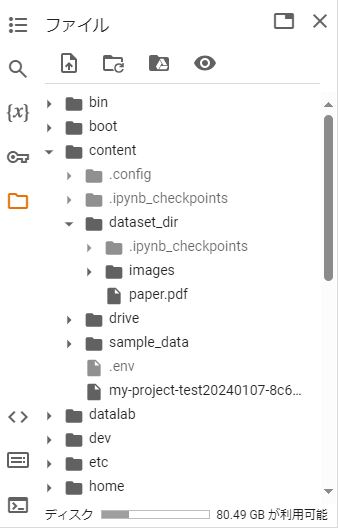

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
from typing import List, Tuple
from typing import Dict, Any
from unstructured.partition.pdf import partition_pdf

In [ ]:
dir_name = "dataset_dir" # フォルダ名
pdf_file_name = "paper.pdf" # PDF名

In [ ]:
def partition_pdf_by_element_type(
    dataset_dir: str, pdf_file_name: str
) -> Tuple[List[str], List[str]]:
    loaded_pdf = partition_pdf(
        filename=os.path.join(dataset_dir, pdf_file_name),
        extract_images_in_pdf=True,
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=os.path.join(dataset_dir, "images"),
    )

    # テーブルとテキストをリストに格納する
    tables, texts = [], []
    for element in loaded_pdf:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(
            type(element)
        ):
            texts.append(str(element))

    return tables, texts

In [ ]:
dataset_dir = os.path.join(os.getcwd(), dir_name)

tables, texts = partition_pdf_by_element_type(
    dataset_dir=dataset_dir, pdf_file_name=pdf_file_name
)

# JSON ファイルに tables の内容を保存
with open(os.path.join(dataset_dir, 'tables.json'), 'w', encoding='utf-8') as json_file:
    json.dump(tables, json_file, ensure_ascii=False, indent=4)

print(f"tables の内容を '{os.path.join(dataset_dir, 'tables.json')}' に保存しました。")

# JSON ファイルに text の内容を保存
with open(os.path.join(dataset_dir, 'texts.json'), 'w', encoding='utf-8') as json_file:
    json.dump(texts, json_file, ensure_ascii=False, indent=4)

print(f"text の内容を '{os.path.join(dataset_dir, 'texts.json')}' に保存しました。")

tables の内容を '/content/dataset_dir/tables.json' に保存しました。
text の内容を '/content/dataset_dir/texts.json' に保存しました。


■ Gemini 関連ライブラリのimport

・geminiの利用にあたってGCPでのプロジェクト作成、APIキー発行、認証キーの発行が必要となります。

・contentフォルダに、認証キーのjsonファイルを読み込むように設定してます。

In [ ]:
import os
import json
import uuid
import base64
import vertexai
import google.generativeai as genai

from typing import Any, Dict, List
from langchain.embeddings import VertexAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma
from langchain_core.documents import Document
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain_community.chat_models import ChatVertexAI
from langchain.schema.messages import HumanMessage
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

In [ ]:
# 環境変数 GOOGLE_APPLICATION_CREDENTIALS を設定 #変更してください。
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "gemini.json"

# プロジェクトIDを設定 #変更してください。
vertexai.init(project='project名')

# APIキーの設定 #変更してください。
api_key = "*********"
genai.configure(api_key=api_key)


In [ ]:

for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-pro
models/gemini-pro-vision


### ■ Gemini Proでテーブル、画像の説明
### 　 ■ テキストの想定質問を取得

In [ ]:
def summarize_tables_with_gemini(
    tables_list: List[str],
    ) -> Dict[str, List[Any]]:
    table_summary_prompt_template = """
    テーブルが与えられます。
    下記に記載されている出力項目に着目して、読み取れることを出力してください。

    # 出力項目:
    - 何がまとめられているテーブルなのか
    - テーブルに記載されているキーワード
    - テーブルから読み取ることができる分析結果

    # テーブル:
    {table}
    """

    table_summary_prompt = ChatPromptTemplate.from_template(
        table_summary_prompt_template
    )

    summarize_model_name = "gemini-pro"
    summarize_model = ChatVertexAI(
        model_name=summarize_model_name,
        max_output_tokens=2048,
        temperature=0.9,
        top_p=1,
    )

    # LCELでチェーンを記述
    summarize_chain = (
        {"table": lambda x: x}
        | table_summary_prompt
        | summarize_model
        | StrOutputParser()
    )
    table_summaries = summarize_chain.batch(
        tables_list, config={"max_concurrency": 5}
    )

    tables_dict = {
        "table_list": tables_list,
        "table_summaries": table_summaries,
    }
    return tables_dict

In [ ]:
# 画像ファイルをBase64エンコードされた文字列に変換
def image_to_base64(image_path: str) -> str:
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
    return encoded_string

# Gemini Pro Visionにて画像の説明を行い、説明結果とbase64を返却する
def summarize_images_with_gemini(image_dir: str) -> Dict[str, List[Any]]:
    image_base64_list = []
    image_summaries_list = []
    image_summary_prompt = """
    入力された画像の内容を詳細に説明してください。
    基本的には日本語で回答してほしいですが、専門用語や固有名詞を用いて説明をする際には英語のままで構いません。
    """

    for image_file_name in sorted(os.listdir(image_dir)):
        if image_file_name.endswith(".jpg"):
            image_file_path = os.path.join(image_dir, image_file_name)

            # encodeを行い、base64をリストに格納する
            image_base64 = image_to_base64(image_file_path)
            image_base64_list.append(image_base64)

            # Geminiで画像の説明を行い、結果をリストに格納する
            summarize_model_name = "gemini-pro-vision"
            summarize_model = ChatVertexAI(
                model_name=summarize_model_name,
                max_output_tokens=2048,
                temperature=0.4,
                top_p=1,
                top_k=32,
            )

            text_message = {"type": "text", "text": image_summary_prompt}
            image_message = {
                "type": "image_url",
                "image_url": {"url": image_file_path},
            }

            response = summarize_model.invoke([HumanMessage(content=[text_message, image_message])])

            image_summaries_list.append(response.content)
            images_dict = {
                "image_list": image_base64_list,
                "image_summaries": image_summaries_list,
            }

            print("image処理中")

    return images_dict

In [ ]:
def hypothetical_queries_with_gemini(
    texts_list: List[str],
    ) -> Dict[str, List[Any]]:
    text_summary_prompt_template = """
    テキストチャンクが与えられます。
    そのチャンクに対して、想定される質問を1つ考えてください。
    下記の制約条件を厳格に守ってください。

    # 制約条件:
    - あなたが考えた質問のみを出力してください
    - 質問を考える際には、質問例を参考にしてください
    - 1つのテキストチャンクに対して、1つの回答を出力してください

    # 質問例:
    - MultiVectorRetrieverとはどのようなものですか？
    - 「Vertex AI(Gemini API)でGemini Proを試す」というブログの著者は誰ですか？
    - Vertex AIのGemini APIではどのようなことができますか？

    # テキストチャンク:
    {text}
    """

    text_summary_prompt = ChatPromptTemplate.from_template(
        text_summary_prompt_template
    )

    summarize_model_name = "gemini-pro"
    summarize_model = ChatVertexAI(
        model_name=summarize_model_name,
        max_output_tokens=2048,
        temperature=0.9,
        top_p=1,
    )

    # LCELでチェーンを記述
    summarize_chain = (
        {"text": lambda x: x}
        | text_summary_prompt
        | summarize_model
        | StrOutputParser()
    )
    text_summaries = summarize_chain.batch(
        texts_list, config={"max_concurrency": 5}
    )
    texts_dict = {
        "texts_list": texts_list,
        "text_summaries": text_summaries,
    }

    return texts_dict

In [ ]:
dataset_dir = os.path.join(os.getcwd(), dir_name)

print("0")
# ここで hypothetical_queries_with_gemini 関数を呼び出していると仮定します
texts_dict = hypothetical_queries_with_gemini(texts_list=texts)
print("1")
# summarize_tables_with_gemini 関数を呼び出してテーブルを要約する
tables_dict = summarize_tables_with_gemini(tables_list=tables)
print("2")
images_dict = summarize_images_with_gemini(
    image_dir=os.path.join(dataset_dir, "images")
)

0
1
2
image処理中
image処理中
image処理中
image処理中
image処理中
image処理中
image処理中
image処理中


In [ ]:
# texts_dictを保存
with open(os.path.join(dataset_dir, 'texts_dict.json'), 'w', encoding='utf-8') as f:
    json.dump(texts_dict, f, ensure_ascii=False, indent=4)

# tables_dictを保存
with open(os.path.join(dataset_dir, 'tables_dict.json'), 'w', encoding='utf-8') as f:
    json.dump(tables_dict, f, ensure_ascii=False, indent=4)

# images_dictを保存
with open(os.path.join(dataset_dir, 'images_dict.json'), 'w', encoding='utf-8') as f:
    json.dump(images_dict, f, ensure_ascii=False, indent=4)

In [ ]:
dataset_dir = os.path.join(os.getcwd(), dir_name)

# texts_dictをロード
with open(os.path.join(dataset_dir, 'texts_dict.json'), 'r', encoding='utf-8') as f:
    texts_dict = json.load(f)

# tables_dictをロード
with open(os.path.join(dataset_dir, 'tables_dict.json'), 'r', encoding='utf-8') as f:
    tables_dict = json.load(f)

# tables_dictをロード
with open(os.path.join(dataset_dir, 'images_dict.json'), 'r', encoding='utf-8') as f:
    images_dict = json.load(f)

### ■ ベクトルDB作成

In [ ]:
def import_data_to_vector_store(
    texts_dict: Dict[str, List[Any]],
    tables_dict: Dict[str, List[Any]],
    images_dict: Dict[str, List[Any]],
    ) -> MultiVectorRetriever:
    embedding_model_name = "textembedding-gecko-multilingual@001"
    # embedding_model_name = "textembedding-gecko@003"
    embedding_function = VertexAIEmbeddings(model_name=embedding_model_name)
    vectorstore = Chroma(
        collection_name="gemini-pro-multi-rag",
        embedding_function=embedding_function,
    )

    # 元の文章を保存するためのストレージ
    store = InMemoryStore()
    id_key = "doc_id"

    # Retrieverの作成
    multivector_retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
        search_kwargs={"k": 6},
    )

    # テキストデータをembedding、vectorstoreに格納する
    doc_ids = [str(uuid.uuid4()) for _ in texts_dict["texts_list"]]
    # チャンクを保存する
    for i, s in enumerate(texts_dict["texts_list"]):
        if s != "":
            multivector_retriever.vectorstore.add_documents(
                [Document(page_content=s, metadata={id_key: doc_ids[i]})]
            )
    # テキストチャンクとidを紐づける
    multivector_retriever.docstore.mset(
        list(zip(doc_ids, texts_dict["texts_list"]))
    )
    print("### Text Data Stored! ###")

    # 想定質問を保存する
    doc_summary_ids = [str(uuid.uuid4()) for _ in texts_dict["texts_list"]]
    for i, s in enumerate(texts_dict["text_summaries"]):
        if s != "":
            multivector_retriever.vectorstore.add_documents(
                [
                    Document(
                        page_content=s, metadata={id_key: doc_summary_ids[i]}
                    )
                ]
            )
    # テキストチャンクとidを紐づける
    multivector_retriever.docstore.mset(
        list(zip(doc_summary_ids, texts_dict["texts_list"]))
    )
    print("### Hypothetical Queries Data Stored! ###")

    # テーブルデータの説明をembedding、vectorstoreに格納する
    table_ids = [str(uuid.uuid4()) for _ in tables_dict["table_list"]]
    # テーブルの説明を保存する
    for i, s in enumerate(tables_dict["table_summaries"]):
        multivector_retriever.vectorstore.add_documents(
            [Document(page_content=s, metadata={id_key: table_ids[i]})]
        )
    # tablesを保存、とidを紐づける
    multivector_retriever.docstore.mset(
        list(zip(table_ids, tables_dict["table_list"]))
    )
    print("### Table Data Stored! ###")

    # 画像データの説明をembedding、vectorstoreに格納する
    img_ids = [str(uuid.uuid4()) for _ in images_dict["image_list"]]
    # 画像の説明を保存する
    for i, s in enumerate(images_dict["image_summaries"]):
        multivector_retriever.vectorstore.add_documents(
            [Document(page_content=s, metadata={id_key: img_ids[i]})]
        )
    # imagesを保存、とidを紐づける
    multivector_retriever.docstore.mset(
        list(zip(img_ids, images_dict["image_list"]))
    )
    print("### Image Data Stored! ###")

    return multivector_retriever

In [ ]:
multivector_retriever = import_data_to_vector_store(
    texts_dict  = texts_dict,  # 修正: texts -> texts_dict
    tables_dict = tables_dict,
    images_dict = images_dict
)
# 処理が完了したことを示すメッセージを出力
print("ベクトルDB作成が完了しました。")

### Text Data Stored! ###
### Hypothetical Queries Data Stored! ###
### Table Data Stored! ###
### Image Data Stored! ###
ベクトルDB作成が完了しました。


### ■ RAGを実行

In [ ]:
from base64 import b64decode
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt

from langchain.chat_models import ChatVertexAI
from langchain.schema.messages import BaseMessage, HumanMessage
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.output_parser import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

In [ ]:
def plt_image_base64(img_base64: str) -> None:
    # Base64データをデコードして画像に変換
    image_data = base64.b64decode(img_base64)
    image = Image.open(io.BytesIO(image_data))

    # PILイメージをNumPy配列に変換
    image_np = np.array(image)

    # 画像を表示
    plt.imshow(image_np)
    plt.axis("off")
    plt.show()

def generate_prompt(data: dict) -> List[HumanMessage]:
    prompt_template = f"""
        以下のcontext（テキストと表）のみに基づいて質問に答えてください。
        入力画像が質問に対して関連しない場合には、画像は無視してください。

        質問:
        {data["question"]}

        context:
        {data["context"]["texts"]}
        """
    text_message = {"type": "text", "text": prompt_template}

    # 画像がRetrivalで取得された場合には画像を追加,エンコードしてmatplotlibで表示する
    # 画像が複数取得されている場合には、関連性が最も高いものをモデルへの入力とする
    if data["context"]["images"]:
        plt_image_base64(data["context"]["images"][0])
        image_url = f"data:image/jpeg;base64,{data['context']['images'][0]}"
        image_message = {"type": "image_url", "image_url": {"url": image_url}}
        return [HumanMessage(content=[text_message, image_message])]
    else:
        return [HumanMessage(content=[text_message])]


# 画像とテキストを分割する
def split_data_type(docs: List[str]) -> Dict[str, List[str]]:
    base64, text = [], []
    for doc in docs:
        try:
            b64decode(doc)
            base64.append(doc)
        except Exception:
            text.append(doc)
    return {"images": base64, "texts": text}


# 画像がない場合にはgemini-proを選択する
def model_selection(message: List[BaseMessage]) -> Any:
    if len(message[0].content) == 1:
        answer_generation_model = "gemini-pro"
    else:
        answer_generation_model = "gemini-pro-vision"

    model = ChatVertexAI(model_name=answer_generation_model)
    response = model(message)
    return response


# Chainを作成、実行する
#def multimodal_rag(retriever: MultiVectorRetriever, question: dict) -> str:
def multimodal_rag(retriever: MultiVectorRetriever, question: str) -> str:
    chain = (
        {
            "context": retriever | RunnableLambda(split_data_type),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(generate_prompt)
        | RunnableLambda(model_selection)
        | StrOutputParser()
    )
    answer = chain.invoke(question)
    return answer

In [ ]:
question_1 = "論文の著者は誰ですか？また所属を教えてください"

try:
    answer_1 = multimodal_rag(multivector_retriever, question_1)
    print(answer_1)
except Exception as e:
    print(f"質問1の処理中にエラーが発生しました: {e}")

論文の著者は、Jimmy Lei Ba、Jamie Ryan Kiros、Geoffrey E Hintonです。所属は記載されていません。


In [ ]:
question_2 = "Transformerのアーキテクチャとはどのようなものですか？"

try:
    answer_2 = multimodal_rag(multivector_retriever, question_2)
    print(answer_2)
except Exception as e:
    print(f"質問2の処理中にエラーが発生しました: {e}")

contextにTransformerのアーキテクチャに関する情報はありません。
